#Objective

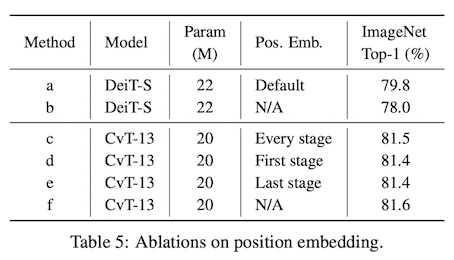

- By tweaking the presence or absence of Position Embedding in the model, we prove that the Convolutional Token Embedding of CvT is completely replacing the Position Embedding.

- For conventional Vision Transformer models(in this experiment, the model is DeiT-S) that recognize images through Position Embedding, performance is reduced when Position Embedding is removed, but for CvT, there is no significant difference in performance.

- DeiT-S and CvT-13 model is trained on Imagenette2 train dataset which is subset of ImageNet, and tested on Imagenette2 test dataset.

## Setup Environment

In [1]:
import sys
sys.path.append('/root/.local/lib/python3.7/site-packages')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!pip install torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2
!pip install -U PyYAML
!pip install tensorboardX 
!pip install yacs
!pip install timm
!pip install einops
!pip install tensorwatch
!pip install ptflops

     |████████████████████████████████| 776.8 MB 17 kB/s 
     |████████████████████████████████| 12.8 MB 53.1 MB/s 
     |████████████████████████████████| 7.6 MB 64.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.11.0+cu113
    Uninstalling torchaudio-0.11.0+cu113:
      Successfully uninstalled torchaudio-0.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.
     |████

In [5]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import torch.utils.data as data

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Load Custom Dataset (Imagenette2)
 - subset of 10 easily classified classes from Imagenet
 - https://github.com/fastai/imagenette

In [7]:
# Hyper parameters
batch_size = 16
num_classes = 10
num_epochs = 20

In [8]:
TRAIN_DATA_PATH = "/content/gdrive/MyDrive/FinalProject/AblationPosEmb/imagenette2/train/"
TEST_DATA_PATH = "/content/gdrive/MyDrive/FinalProject/AblationPosEmb/imagenette2/val/"

In [16]:
import glob
import cv2
import os
import numpy as np
import torch
import torch.nn
import torchvision
import torchvision.utils
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from PIL import Image
import matplotlib.pyplot as plt

#### Load Data from Local File

In [10]:
def Data(path):
    # Retrieve the list of ALL folders and files inside the base folder
    file_list = glob.glob(path + "*") # 10 folders in path directory

    init_data = []
    # Create a list that would contain the paths to all the images in the dataset
    for class_path in file_list:
        class_name = class_path.split("/")[-1] # extract the class name.
        # Retrieve each image in their folders
        for img_path in glob.glob(class_path + "/*.JPEG"): # for each file with the extension ".JPEG"
            # Check for problematic images
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)                 
            if type(img) is np.ndarray:
                if img.size == 0:
                    continue
            if img is None:
                continue
            init_data.append([img_path, class_name]) # append image file path to init_data list, and its class name

    return init_data

#### Data to Dataset

In [11]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        # Dictionary containing mapping between string and number (class label)
        self.class_map = {"n01440764" : 0, "n02102040": 1, "n02979186":2, "n03000684":3, 
                          "n03028079": 4, "n03394916":5, "n03417042":6, "n03425413":7, 
                          "n03445777":8, "n03888257":9}
        # Set image dimensions
        self.img_dim = (224, 224) 
        # Perform any transformations
        self.transform = transform

    def __len__(self):
        return len(self.data)

    # This function is called when an element of this class is accessed via dataset[index]
    def __getitem__(self, index):
        # Get image path and class name
        img_path, class_name = self.data[index] # tuple from __init__()
        # Obtain the image from its path and resize it to the required dimension
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) 
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name] # get the class label
        pil_img=Image.fromarray(img) # convert ndarray to PIL
        # Perform transforms if there are any
        if self.transform:
            img_tensor = self.transform(pil_img)
        # Convert class label to a tensor
        class_id = torch.tensor(class_id) 

        return img_tensor, class_id

In [20]:
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


classes = ('tench', 'English springer', 'cassette player', 'chain saw', 'church', 
           'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute')

In [21]:
train_data = Data(TRAIN_DATA_PATH) # Data loaded from TRAIN_DATA_PATH
train_set = CustomDataset(train_data, transform = train_transform) # Dataset consisted of train_data
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [22]:
test_data = Data(TEST_DATA_PATH) # Data loaded from TRAIN_DATA_PATH
test_set = CustomDataset(test_data, transform = test_transform) # Dataset consisted of train_data
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [23]:
batch = next(iter(train_loader))

images, labels = batch

print(images.shape)
print(labels)

torch.Size([16, 3, 224, 224])
tensor([7, 1, 1, 0, 0, 8, 2, 2, 1, 0, 1, 6, 3, 9, 8, 0])


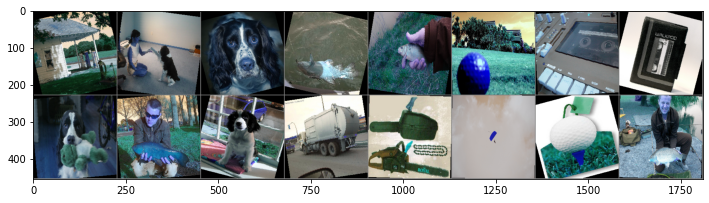

	gas pump 	English springer 	English springer 	tench 	tench 	golf ball 	cassette player 	cassette player 	English springer 	tench 	English springer 	garbage truck 	chain saw 	parachute 	golf ball 	tench


In [24]:
from PIL import Image
import matplotlib.pyplot as plt
# Inverse the normalisation
def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def imshow(img):
    img = inverse_normalize(tensor=img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  
    npimg = img.numpy()
    plt.figure(figsize=(12,12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(classes[labels[j]]) for j in range(batch_size)))

# Define the CvT-13 Model

In [25]:
cd /content/gdrive/MyDrive/FinalProject/CvT-main

/content/gdrive/MyDrive/FinalProject/CvT-main


In [26]:
from __future__ import absolute_import # make py3 grammer available for py2
from __future__ import division
from __future__ import print_function

import argparse
import logging
import os
import pprint
import time

import torch.nn.parallel
import torch.optim
from torch.utils.collect_env import get_pretty_env_info
from tensorboardX import SummaryWriter
import torchvision.transforms as transforms

from tools import _init_paths
from config import config
from config import update_config
from config import save_config
from core.loss import build_criterion
from core.function import train_one_epoch, test
from dataset import build_dataloader
from models import build_model
from optim import build_optimizer
from scheduler import build_lr_scheduler
from utils.comm import comm
from utils.utils import create_logger
from utils.utils import init_distributed
from utils.utils import setup_cudnn
from utils.utils import summary_model_on_master
from utils.utils import resume_checkpoint
from utils.utils import save_checkpoint_on_master
from utils.utils import save_model_on_master

class Args:
  def __init__(self, cfg, local_rank, port, opts):
    self.cfg = cfg
    self.local_rank = local_rank
    self.port = port
    self.opts = opts

cfg = 'experiments/imagenet/cvt/cvt-13-224x224.yaml'

# Load Model - Position Embedding is Preserved
 - First, Turn on the Position Embedding!
 - Just Fill the 'opts' with ''MODEL.SPEC.POS_EMBED' and '[True, True, True]'

In [28]:
opts = ['MODEL.SPEC.POS_EMBED', '[True, True, True]']

args = Args(cfg, 0, 9000, opts)

init_distributed(args) # set num_gpus, distributed and specify the gpu to use (local_rank)
setup_cudnn(config) # set cudnn

update_config(config, args) # update config from yaml file, arguments, and default
final_output_dir = create_logger(config, args.cfg, 'train')
tb_log_dir = final_output_dir

if comm.is_main_process():
    output_config_path = os.path.join(final_output_dir, 'config.yaml')
    save_config(config, output_config_path)

model = build_model(config)

=> merge config from experiments/imagenet/cvt/cvt-13-224x224.yaml
=> creating OUTPUT ...
=> creating OUTPUT/imagenet/cvt-13-224x224 ...
=> setup logger ...


2022-05-19 02:48:23,346:[P:71]:Rank[0/1] => init weight of Linear from trunc norm
2022-05-19 02:48:23,375:[P:71]:Rank[0/1] => init bias of Linear to zeros
2022-05-19 02:48:23,378:[P:71]:Rank[0/1] => init weight of Linear from trunc norm
2022-05-19 02:48:23,381:[P:71]:Rank[0/1] => init bias of Linear to zeros
2022-05-19 02:48:23,384:[P:71]:Rank[0/1] => init weight of Linear from trunc norm
2022-05-19 02:48:23,389:[P:71]:Rank[0/1] => init bias of Linear to zeros
2022-05-19 02:48:23,392:[P:71]:Rank[0/1] => init weight of Linear from trunc norm
2022-05-19 02:48:23,395:[P:71]:Rank[0/1] => init bias of Linear to zeros
2022-05-19 02:48:23,397:[P:71]:Rank[0/1] => init weight of Linear from trunc norm
2022-05-19 02:48:23,400:[P:71]:Rank[0/1] => init bias of Linear to zeros
2022-05-19 02:48:23,401:[P:71]:Rank[0/1] => init weight of Linear from trunc norm
2022-05-19 02:48:23,405:[P:71]:Rank[0/1] => init bias of Linear to zeros
2022-05-19 02:48:23,419:[P:71]:Rank[0/1] => init weight of Linear from

## To Classify 10 Classes Dataset, Resturct the Final Layer!
 - out_features: 1000 to 10

In [29]:
model.head # The last layer of this model

Linear(in_features=384, out_features=1000, bias=True)

In [30]:
model.head = nn.Linear(in_features = model.head.in_features, out_features = num_classes, bias = True )
model=model.to(device)

model.head # The last layer of this model

Linear(in_features=384, out_features=10, bias=True)

In [31]:
params_to_update = []

# Check unfreezed layer
for name, param in model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)

# Loss and Optimiser
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

## Train and Test

In [32]:
n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // batch_size) 
print(f'Total steps: {n_total_steps}')
print(f'Iterations per epoch: {n_iterations}')

# iterate 'pre_epoch' to 'pre_epoch + num_epohcs'
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    model.train()                               

    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass and Optimise
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Print
    if (i+1) == n_iterations:
      print(f'Epoch {epoch+1}/{num_epochs}, Iteration {i+1}/{n_iterations}, Loss={loss.item()} ')

Total steps: 9517
Iterations per epoch: 595
Epoch 1/20, Iteration 595/595, Loss=1.7302486896514893 
Epoch 2/20, Iteration 595/595, Loss=1.5997380018234253 
Epoch 3/20, Iteration 595/595, Loss=2.1415977478027344 
Epoch 4/20, Iteration 595/595, Loss=0.8680800795555115 
Epoch 5/20, Iteration 595/595, Loss=1.0536118745803833 
Epoch 6/20, Iteration 595/595, Loss=0.8698691129684448 
Epoch 7/20, Iteration 595/595, Loss=1.1352901458740234 
Epoch 8/20, Iteration 595/595, Loss=1.3076227903366089 
Epoch 9/20, Iteration 595/595, Loss=1.6114157438278198 
Epoch 10/20, Iteration 595/595, Loss=1.1234012842178345 
Epoch 11/20, Iteration 595/595, Loss=1.2535407543182373 
Epoch 12/20, Iteration 595/595, Loss=0.5759753584861755 
Epoch 13/20, Iteration 595/595, Loss=1.6414124965667725 
Epoch 14/20, Iteration 595/595, Loss=0.9985688328742981 
Epoch 15/20, Iteration 595/595, Loss=1.2999604940414429 
Epoch 16/20, Iteration 595/595, Loss=0.7580646276473999 
Epoch 17/20, Iteration 595/595, Loss=0.74656897783279

In [33]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]


  model.eval()
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) 

    # Get predictions
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (y_preds == labels).sum().item()

    # Keep track of each class
    for i in range(batch_size):

      # test_size is not divided with by batch_size
      # When the last batch is arrived, just skip to prevent bounding error
      if(len(labels)!=batch_size):
          continue

      label = labels[i]
      pred = y_preds[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  # Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy of the WHOLE CNN = {round(acc,2)} %')

  for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {round(acc,2)} %')

Test Accuracy of the WHOLE CNN = 64.76 %
Accuracy of tench: 82.17 %
Accuracy of English springer: 72.66 %
Accuracy of cassette player: 66.19 %
Accuracy of chain saw: 46.63 %
Accuracy of church: 66.5 %
Accuracy of French horn: 67.51 %
Accuracy of garbage truck: 77.89 %
Accuracy of gas pump: 52.03 %
Accuracy of golf ball: 49.62 %
Accuracy of parachute: 67.69 %


# Load Model - Position Embedding is Removed
 - Now, Turn off the Position Embedding!
 - Just Fill the 'opts' with ''MODEL.SPEC.POS_EMBED' and '[False, False, False]'

In [34]:
opts = ['MODEL.SPEC.POS_EMBED', '[False, False, False]']

args = Args(cfg, 0, 9000, opts)

init_distributed(args) # set num_gpus, distributed and specify the gpu to use (local_rank)
setup_cudnn(config) # set cudnn

update_config(config, args) # update config from yaml file, arguments, and default
final_output_dir = create_logger(config, args.cfg, 'train')
tb_log_dir = final_output_dir

if comm.is_main_process():
    output_config_path = os.path.join(final_output_dir, 'config.yaml')
    save_config(config, output_config_path)

model = build_model(config)

=> merge config from experiments/imagenet/cvt/cvt-13-224x224.yaml
=> creating OUTPUT ...
=> creating OUTPUT/imagenet/cvt-13-224x224cvt-13-224x224 ...
=> setup logger ...


2022-05-19 03:37:25,178:[P:71]:Rank[0/1] => init weight of Linear from trunc norm
2022-05-19 03:37:25,178:[P:71]:Rank[0/1] => init weight of Linear from trunc norm
2022-05-19 03:37:25,186:[P:71]:Rank[0/1] => init bias of Linear to zeros
2022-05-19 03:37:25,186:[P:71]:Rank[0/1] => init bias of Linear to zeros
2022-05-19 03:37:25,190:[P:71]:Rank[0/1] => init weight of Linear from trunc norm
2022-05-19 03:37:25,190:[P:71]:Rank[0/1] => init weight of Linear from trunc norm
2022-05-19 03:37:25,201:[P:71]:Rank[0/1] => init bias of Linear to zeros
2022-05-19 03:37:25,201:[P:71]:Rank[0/1] => init bias of Linear to zeros
2022-05-19 03:37:25,205:[P:71]:Rank[0/1] => init weight of Linear from trunc norm
2022-05-19 03:37:25,205:[P:71]:Rank[0/1] => init weight of Linear from trunc norm
2022-05-19 03:37:25,215:[P:71]:Rank[0/1] => init bias of Linear to zeros
2022-05-19 03:37:25,215:[P:71]:Rank[0/1] => init bias of Linear to zeros
2022-05-19 03:37:25,219:[P:71]:Rank[0/1] => init weight of Linear from

## To Classify 10 Classes Dataset, Resturct the Final Layer!
 - out_features: 1000 to 10

In [35]:
model.head # The last layer of this model

Linear(in_features=384, out_features=1000, bias=True)

In [36]:
model.head = nn.Linear(in_features = model.head.in_features, out_features = num_classes, bias = True )
model=model.to(device)

model.head # The last layer of this model

Linear(in_features=384, out_features=10, bias=True)

In [37]:
params_to_update = []

# Check unfreezed layer
for name, param in model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)

# Loss and Optimiser
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

## Train and Test

In [38]:
n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // batch_size) 
print(f'Total steps: {n_total_steps}')
print(f'Iterations per epoch: {n_iterations}')

# iterate 'pre_epoch' to 'pre_epoch + num_epohcs'
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    model.train()                               

    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass and Optimise
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Print
    if (i+1) == n_iterations:
      print(f'Epoch {epoch+1}/{num_epochs}, Iteration {i+1}/{n_iterations}, Loss={loss.item()} ')

Total steps: 9517
Iterations per epoch: 595
Epoch 1/20, Iteration 595/595, Loss=2.483574151992798 
Epoch 2/20, Iteration 595/595, Loss=1.9384852647781372 
Epoch 3/20, Iteration 595/595, Loss=1.3746527433395386 
Epoch 4/20, Iteration 595/595, Loss=1.3122189044952393 
Epoch 5/20, Iteration 595/595, Loss=0.9446943998336792 
Epoch 6/20, Iteration 595/595, Loss=1.3618676662445068 
Epoch 7/20, Iteration 595/595, Loss=1.6459507942199707 
Epoch 8/20, Iteration 595/595, Loss=1.5200525522232056 
Epoch 9/20, Iteration 595/595, Loss=1.1917288303375244 
Epoch 10/20, Iteration 595/595, Loss=1.2762048244476318 
Epoch 11/20, Iteration 595/595, Loss=1.280260682106018 
Epoch 12/20, Iteration 595/595, Loss=1.2359309196472168 
Epoch 13/20, Iteration 595/595, Loss=0.9691791534423828 
Epoch 14/20, Iteration 595/595, Loss=1.448541522026062 
Epoch 15/20, Iteration 595/595, Loss=0.7953172326087952 
Epoch 16/20, Iteration 595/595, Loss=0.3506939113140106 
Epoch 17/20, Iteration 595/595, Loss=1.1584182977676392 

In [39]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]


  model.eval()
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) 

    # Get predictions
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (y_preds == labels).sum().item()

    # Keep track of each class
    for i in range(batch_size):

      # test_size is not divided with by batch_size
      # When the last batch is arrived, just skip to prevent bounding error
      if(len(labels)!=batch_size):
          continue

      label = labels[i]
      pred = y_preds[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  # Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy of the WHOLE CNN = {round(acc,2)} %')

  for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {round(acc,2)} %')

Test Accuracy of the WHOLE CNN = 64.0 %
Accuracy of tench: 70.54 %
Accuracy of English springer: 70.38 %
Accuracy of cassette player: 73.01 %
Accuracy of chain saw: 36.53 %
Accuracy of church: 66.75 %
Accuracy of French horn: 58.88 %
Accuracy of garbage truck: 73.01 %
Accuracy of gas pump: 60.62 %
Accuracy of golf ball: 59.15 %
Accuracy of parachute: 71.79 %


# Result
 ### Position embedding is preserved          
 - DeiT-S: 58.73%
 - CvT-13: 64.76%

### Position embedding removed          
 - DeiT-S: 56.1%
 - CvT-13: 64.0%


##References
 - https://github.com/facebookresearch/deit
 - https://github.com/rwightman/pytorch-image-models/tree/master/timm